# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [1]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [2]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [3]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [4]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

In [8]:
#Join neighbourhood and its coordinates into one dataframe
mean_neighbourhood = to_data.groupby(to_data['neighbourhood']).mean().reset_index()
mean_neighbourhood  = mean_neighbourhood.drop('neighbourhood',axis = 1)
neighbourhood_value_joined_locations = pd.concat([df_neighbourhood_locations,mean_neighbourhood],axis=1,join="inner")
neighbourhood_value_joined_locations = neighbourhood_value_joined_locations.drop([],axis=1)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [54]:
# Getting the data from the top 10 expensive neighbourhoods
data = to_data.reset_index().drop("year",axis = 1)
grouped_data = data.groupby('neighbourhood').mean()
top_10_expensive = grouped_data.sort_values('average_house_value',ascending = False).head(10)


# Calculate the mean number of dwelling types units per year

dwelling_types = to_data.columns[1:9]
mean_dwelling = to_data[dwelling_types].groupby(to_data.index).mean()
avg_house_value = to_data["average_house_value"].groupby(to_data.index).mean()
dwelling_types = to_data.columns[1:9]
sum_dwelling = to_data[dwelling_types].groupby(to_data.index).sum()

# Calculate the average monthly shelter costs for owned and rented dwellings
shelter_cost=["shelter_costs_owned","shelter_costs_rented"]
avg_shelter_costs = to_data[shelter_cost].groupby(to_data.index).mean()

#Average House Value by neighbourhood 
to_data_2= to_data.reset_index()
neighbourhood_house = ["year","neighbourhood","average_house_value"]
average_house_value_by_neighbourhood=to_data_2[neighbourhood_house]


### Panel Visualization Functions

In [86]:
# Define Panel visualization functions
def neighbourhood_map():
    """Neighbourhood Map"""
   
    map_plot = px.scatter_mapbox(
        neighbourhood_value_joined_locations,
        lat = 'lat',
        lon = 'lon',
        color = 'average_house_value',
        hover_data = neighbourhood_value_joined_locations.columns[3:14]
    )
    return map_plot


def create_bar_chart(data, title, xlabel, ylabel, color):
    """
    Create a barplot based in the data argument.
    """
    
    fig = plt.figure()
    bar_chart = data.plot.bar(color=color)
    bar_chart.set_xlabel(xlabel, fontsize=12)
    bar_chart.set_ylabel(ylabel, fontsize=12)
    bar_chart.set_title(title, fontsize=14, fontweight="bold")    
    plt.show()
    plt.close(fig)
    return fig

def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """

    fig = plt.figure()
    line_chart = data.plot.line(color=color)
    line_chart.set_xlabel(xlabel, fontsize=12)
    line_chart.set_ylabel(ylabel, fontsize=12)
    line_chart.set_title(title, fontsize=14, fontweight="bold")    
    plt.show()
    plt.close(fig)
    return fig

def average_house_value():
    """Average house values per year."""
    
    return create_line_chart(avg_house_value,"Average House Value in Toronto","year","Avg House Value","blue")
    

def average_value_by_neighbourhood():
    """Average house values by neighbourhood."""
    
    return average_house_value_by_neighbourhood.hvplot.line(
    title= 'Average House Value per Neighbourhood',
    x='year',
    y='average_house_value',
    xlabel='Year',
    ylabel='Average House Value',
    groupby='neighbourhood',
    yformatter= '$%.1f'
)

def number_dwelling_types():
    """Number of dwelling types per year"""
    
    # Bar chart for 2001
    return create_bar_chart(sum_dwelling.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")
    # Bar chart for 2006
    return create_bar_chart(sum_dwelling.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")
    # Bar chart for 2011
    return create_bar_chart(sum_dwelling.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")
    # Bar chart for 2016
    return create_bar_chart(sum_dwelling.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")
    
def average_house_value_snapshot():
    """Average house value for all Toronto's neighbourhoods per year."""

    fig = px.bar(to_data_2, 
             height = 1000,
             x="neighbourhood",
             y="average_house_value",
             color = 'average_house_value',
             facet_row="year")
    return fig

def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    
    data = to_data.reset_index().drop("year",axis = 1)
    grouped_data = data.groupby('neighbourhood').mean()
    top_10_expensive = grouped_data.sort_values('average_house_value',ascending = False).head(10)
    
    return top_10_expensive.hvplot.bar(
    height = 500,
    title = "Top 10 Expensive Neighbourhood in Toronto",
    y = 'average_house_value',
    xlabel = "Neighbourhood",
    ylabel = "Average House Price",
    yformatter = "%.1f",
    rot = 90)

def sunburts_cost_analysis():
    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""
    expensive_neighbourhoods_per_year = to_data_2[to_data_2["neighbourhood"].isin(top_10_expensive.index)].reset_index()
    fig = px.sunburst(
        expensive_neighbourhoods_per_year,
        width = 1000,
        height = 1000,
        title = "Costs Analysis of Most Expensive Neighbourhoods in Toronto Per Year",
        path = ['year','neighbourhood'],
        hover_data =['shelter_costs_owned'],
        values = 'average_house_value',
        color = 'shelter_costs_owned',
        color_continuous_scale= 'Blues',
    )
    return fig

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

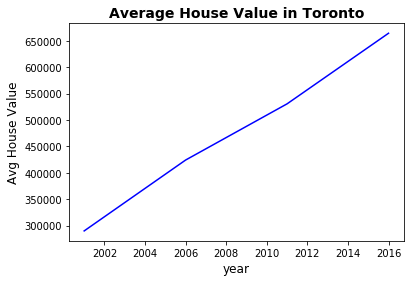

In [81]:
# Create a Title for the Dashboard
# YOUR CODE HERE!

# Define a welcome text
# YOUR CODE HERE!
welcome_column = pn.Column("## This dashboard presents House Price Analysis of Toronto Area from 2001 to 2016 based on neighbourhood ",neighbourhood_map())
neighbourhood_analysis = pn.Column('## Neighbourhood Analysis', average_house_value(),average_value_by_neighbourhood(),top_most_expensive_neighbourhoods() )
sunburst_plot_analysis= pn.Column('## Sunburst Plot Analysis',sunburts_cost_analysis())
bar_row_facet_analysis = pn.Column('##neighbourhood average house value',average_house_value_snapshot())
# Create a tab layout for the dashboard
# YOUR CODE HERE!


# Create the main dashboard
# YOUR CODE HERE!
dashboard = pn.Tabs(
    (
        "Welcome",
        welcome_column
    ),
    (
        "Neighbourhood Analysis",
        neighbourhood_analysis
    ),
    (
        "Sunburst Plot Costs Analysis",
        sunburst_plot_analysis
    ),
    (
        "neighbourhood average house value in Bar",
        bar_row_facet_analysis)
)

## Serve the Panel Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Column
        [0] Markdown(str)
        [1] Matplotlib(Figure)
        [2] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                [1] VSpacer()
        [3] HoloViews(Bars)
    [2] Column
        [0] Markdown(str)
        [1] Plotly(Figure, visible=False)
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure, visible=False)
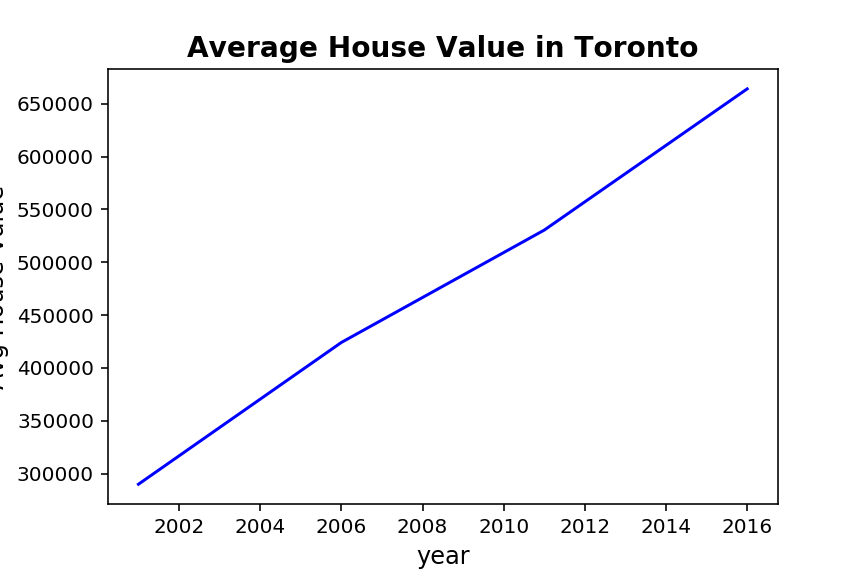

In [82]:
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [37]:
# neighbourhood_map().show()

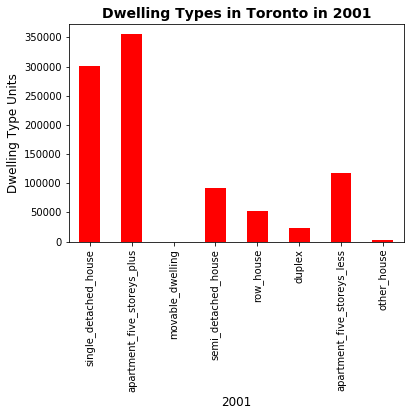

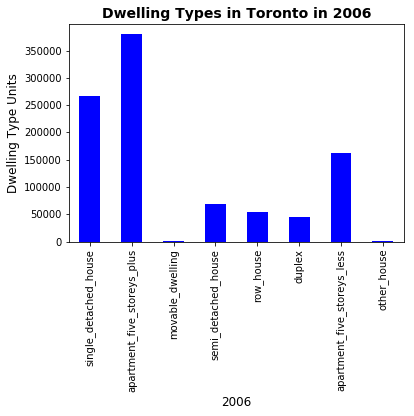

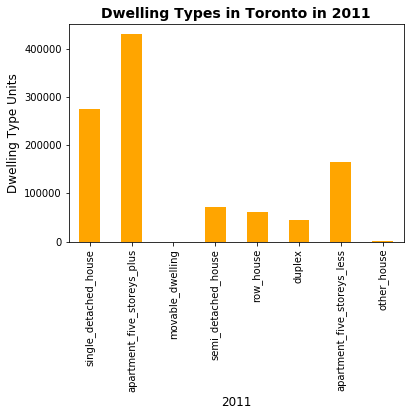

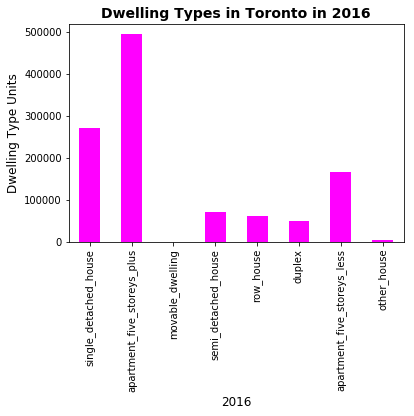

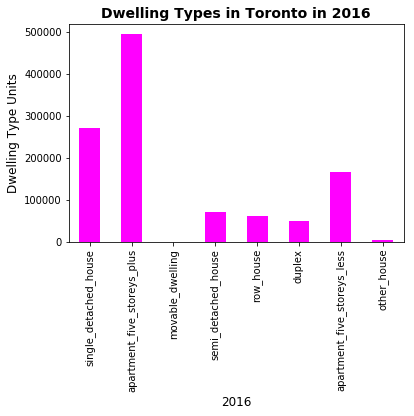

In [87]:
#create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
create_bar_chart(sum_dwelling.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
create_bar_chart(sum_dwelling.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
create_bar_chart(sum_dwelling.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
create_bar_chart(sum_dwelling.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

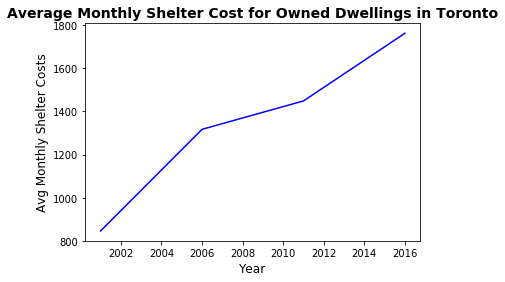

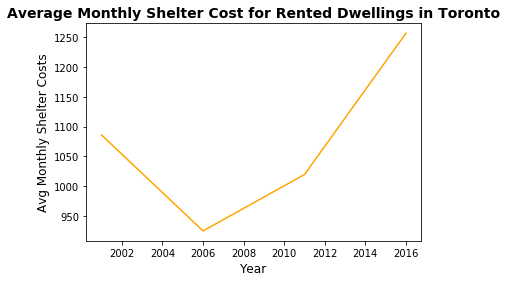

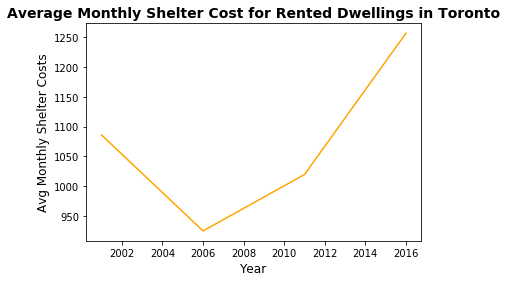

In [88]:
#create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
create_line_chart(avg_shelter_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
create_line_chart(avg_shelter_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

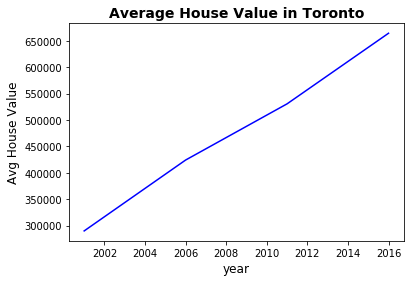

In [41]:
 average_house_value()

In [64]:
average_value_by_neighbourhood()

:DynamicMap   [neighbourhood]
   :Curve   [year]   (average_house_value)

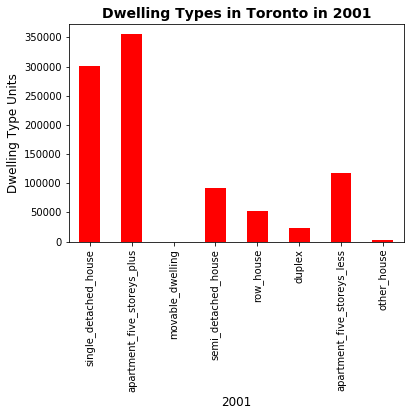

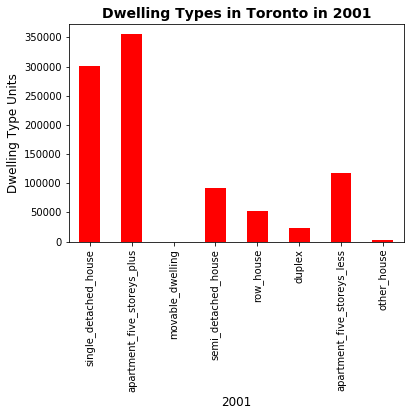

In [69]:
number_dwelling_types()

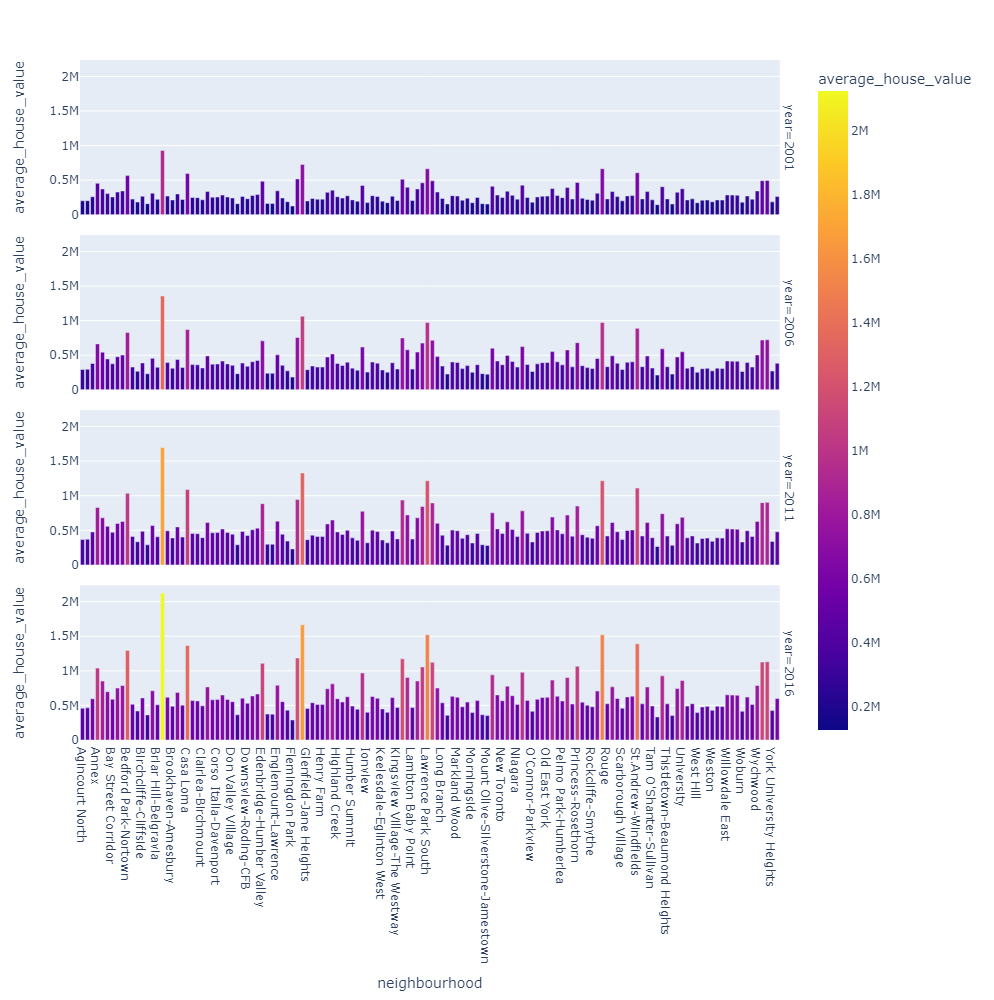

In [45]:
average_house_value_snapshot()

In [49]:
top_most_expensive_neighbourhoods()

:Bars   [neighbourhood]   (average_house_value)

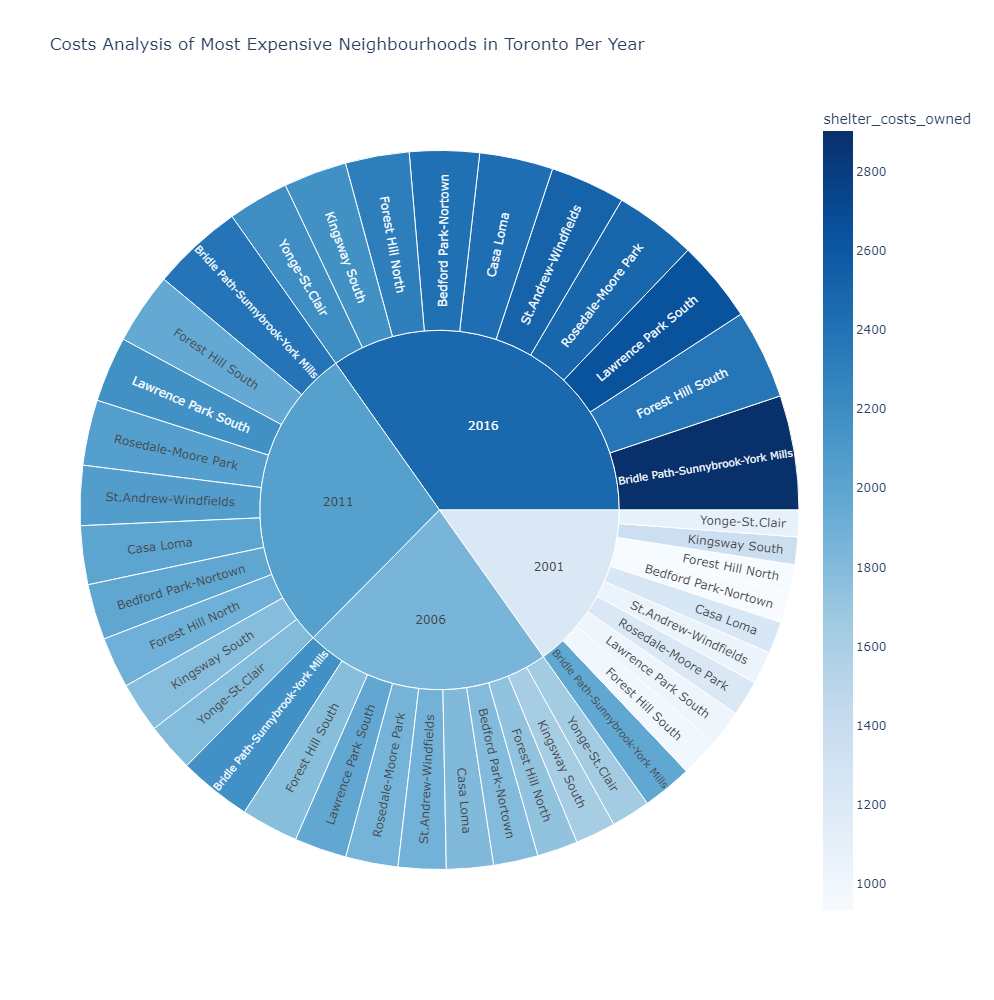

In [47]:
sunburts_cost_analysis()